In [2]:
import sys
import pandas as pd
import math
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import allel
import warnings
from pandas.core.common import SettingWithCopyWarning
from sklearn import metrics
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

<h3>Get threshold values from "null" simulations</h3>

In [7]:
demog = 'stationary'
rr = 'fixed'
mu = 'fixed'

####GET HIGHEST CLR VALUE FROM SIMULATIONS WITH NO SWEEPS####
lst = []
for rep in range(1,201):
    try:
        df = pd.read_csv(sf_inPath + str(rep) + ".out", sep='\t', header=0)
        lst.append(df['LR'].max())
    except Exception:
        pass
sf_threshold = np.max(lst)   


####GET HIGHEST H12 VALUE FROM SIMULATIONS WITH NO SWEEPS####
lst = []
for rep in range(1,201):
    try:
        df = pd.read_csv(h_inPath + str(rep) + "_1kb_snp.txt", sep='\t', header=0)
        lst.append(df['H12'].max())
    except Exception:
        pass
h_threshold = np.max(lst)

<h3>Code for producing plots for recurrent sweep simulations</h3>

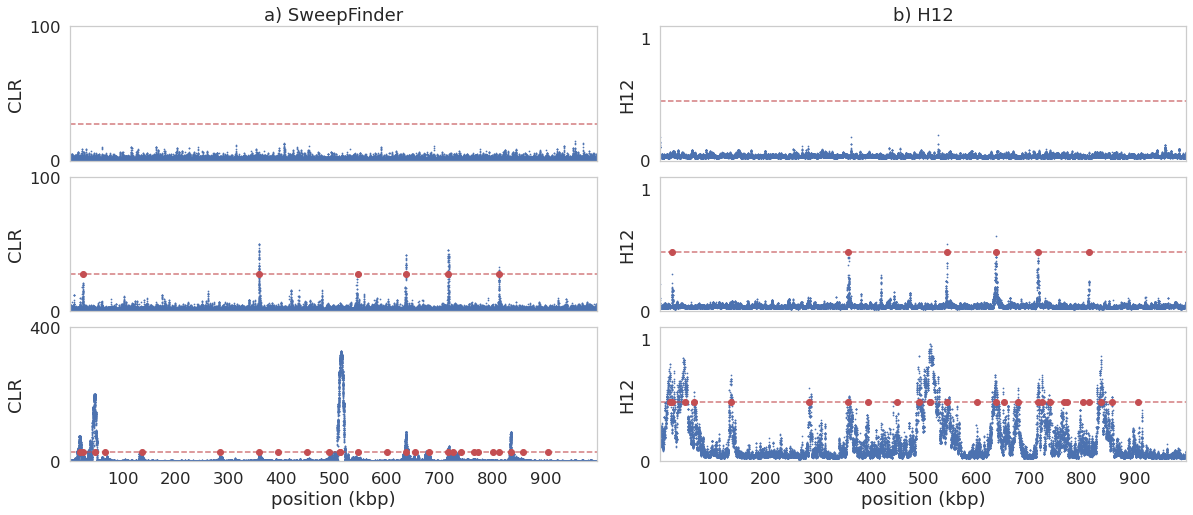

In [29]:
#####PLOT SWEEPFINDER2 AND H12 RESULTS#####
#Choose replicate to plot
r=22 
#Set size of data points
markersize=0.5
#Set y limits
sf_ylim=100
h_ylim=1.1
sns.set(rc={'figure.figsize':(20,8),'axes.facecolor':'white','axes.edgecolor': '.8'},font_scale=1.5)
#Loop through 2Nes values
for i,j in enumerate(['100', '1000', '10000']):
    df = pd.read_csv(sfFile + j +
                     "/"+str(r)+".out", sep='\t', header=0)
    
    #Read in .fixed file
    fixed = pd.read_csv(fixedFile + j + "/"+str(r)+".fixed", 
                        skiprows=2, 
                        sep=' ',
                       names=['tempID', 'permID', 'mutType', 'location', 's', 'h', 'initial_subpop', 'origin_gen',
                             'fix_gen'])
    
    #Keep only beneficial fixations
    fixed = fixed[fixed.mutType=='m0']
    #Keep only fixations that occured up to 0.5N generations ago
    fixed = fixed[fixed.fix_gen >= (17*7000)-(0.5*7000)]
    #Set up subplot
    plt.subplot(3,2,i*2+1)
    #Plot scatter for SF2
    plt.scatter(x=df.location, y=df['LR'], s=markersize)
    #Plot beneficial mutations
    plt.plot(fixed.location,[sf_threshold for x in range(0, len(fixed))],'ro')
    #Plot threshold line
    plt.axhline(sf_threshold, color='r', linestyle='--', alpha=0.75)
    #Set y limits
    plt.ylim([0, sf_ylim])
    plt.yticks([0, sf_ylim])
    plt.margins(x=0)
    plt.ylabel('CLR')
    if(i==0):
        plt.title('a) SweepFinder')
        
    if(i==2):
        plt.xlabel('position (kbp)')
        #Set x ticks to kb values
        plt.xticks([x for x in range(100000, 1000000, 100000)], ['100','200','300','400','500','600','700','800','900'])
    else:
        plt.xticks([])
    #Read in H12 results
    df = pd.read_csv(hFile+j+"/"+str(r)+"_1kb_snp.txt", sep='\t', header=0)
    plt.subplot(3,2,i*2+2)
    #Plot 
    plt.scatter(x=df.snp_position, y=df['H12'], s=markersize)
    plt.plot(fixed.location,[h_threshold for x in range(0, len(fixed))],'ro')
    plt.axhline(h_threshold, color='r', linestyle='--', alpha=0.75)
    plt.ylim([0, h_ylim])
    plt.yticks([0, 1])
    plt.margins(x=0)    
    if(i==0):
        plt.title('b) H12')
    plt.ylabel('H12')
    
    if(i==2):
        plt.xlabel('position (kbp)')
        plt.xticks([x for x in range(100000, 1000000, 100000)], ['100','200','300','400','500','600','700','800','900'])
    else:
        plt.xticks([])

#Adjust space between subplots
plt.subplots_adjust(wspace=0.12, hspace=0.12)

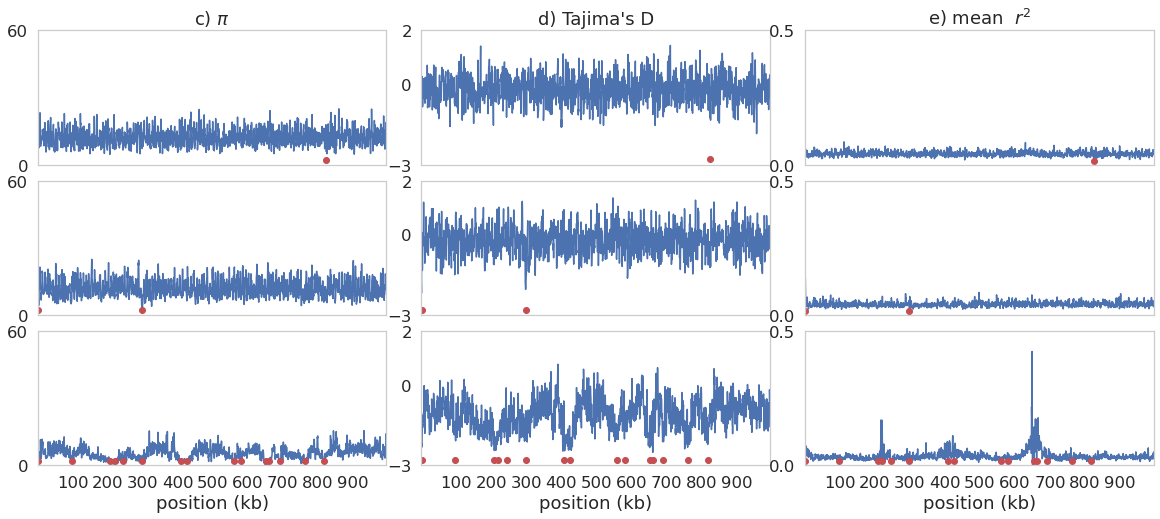

In [7]:
#####PLOT SUMMARY STATISTICS#####
sns.set(rc={'figure.figsize':(20,8),'axes.facecolor':'white','axes.edgecolor': '.8'},font_scale=1.5)
#Create list for subplots
lst = [0,3,6]
#Set plot labels
ylabs = [r'c) $\pi$', "d) Tajima's D", r"e) mean  $r^2$"]
for i,j in enumerate(['100', '1000', '10000']):
    df = pd.read_csv(statsFile+j+"/" + str(r)+".stats", sep='\t',
                header=0)
    
    #Read in .fixed file
    fixed = pd.read_csv(fixedFile + j + "/"+str(r)+".fixed", 
                        skiprows=2, 
                        sep=' ',
                       names=['tempID', 'permID', 'mutType', 'location', 's', 'h', 'initial_subpop', 'origin_gen',
                             'fix_gen'])
    
    
    #Keep only beneficial fixations
    fixed = fixed[fixed.mutType=='m0']
    #Keep only fixations that occured up to 1Ne generations ago
    fixed = fixed[fixed.fix_gen >= (17*7000)-(0.5*7000)]
    #Convert fixed locations to window numbers
    fixed['location'] = [int(x) for x in np.round(fixed.location/500)]

    #Loop through stats to be plotted
    for a, stat in enumerate(['thetapi', 'tajimasd', 'meanrsq']):
        #Set up subplot
        sp = lst[i]+a+1
        plt.subplot(3,3,sp)
        plt.plot(df[stat])
        if(stat=='thetapi'):
            plt.ylim([0,60])
            plt.yticks([0,60])
            plt.plot(fixed.location,[2 for x in range(0, len(fixed))],'ro')
            
        elif(stat=='tajimasd'):
            plt.ylim([-3, 2])
            plt.yticks([-3, 0, 2])
            plt.plot(fixed.location,[-2.8 for x in range(0, len(fixed))],'ro')
            
        else:
            plt.ylim([0, 0.5])
            plt.yticks([0, 0.5])
            plt.plot(fixed.location,[0.015 for x in range(0, len(fixed))],'ro')

        plt.margins(x=0)
        
        #Set xticks for bottom plots, and remove for all others
        if(sp>=7):
            plt.xlabel('position (kb)')
            plt.xticks([x for x in range(200, 2000, 200)], ['100','200','300','400','500','600','700','800','900'])
        else:plt.xticks([])
            
        if(sp<=3):
            plt.title(ylabs[sp-1])
#Adjust spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.12)

<h3>Code for producing plots for single sweep simulations</h3>

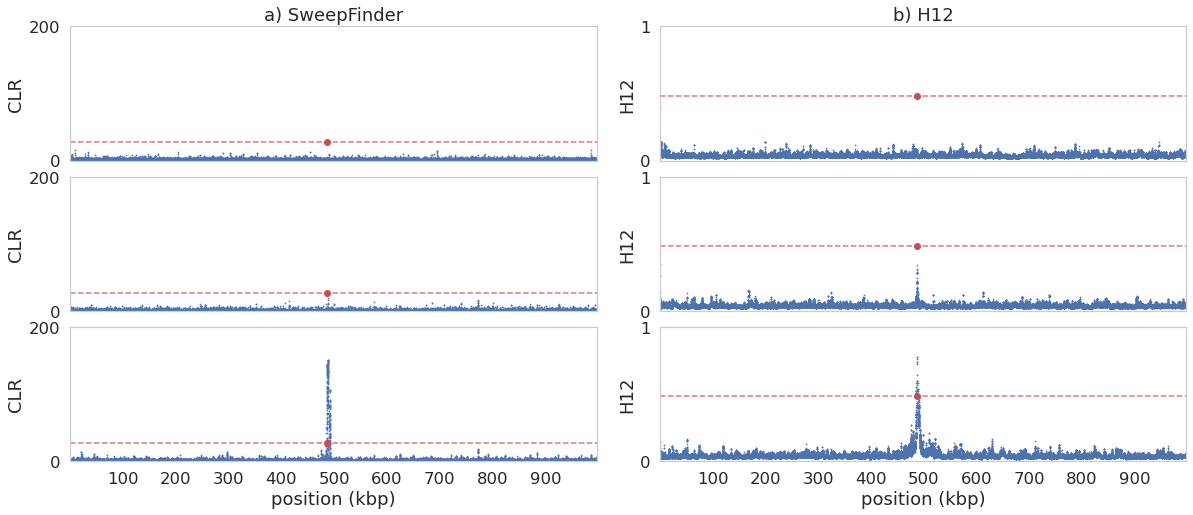

In [11]:
#####PLOT SF2 AND H12 INFERENCE#####

#Set marker size
markersize = 0.5
#set replicate to plot
r=1

sns.set(rc={'figure.figsize':(20,8),'axes.facecolor':'white','axes.edgecolor': '.8'},font_scale=1.5)
#Loop through 2Nes values
for i,j in enumerate(['100', '1000', '10000']):
    df = pd.read_csv(sfFile + j +"/"+str(r)+".out", sep='\t', header=0)
    #Set subplot and plot scatter of inference
    plt.subplot(3,2,i*2+1)
    plt.scatter(x=df.location, y=df['LR'], s=markersize)
    #Plot position of sweep 
    plt.plot(487410,sf_threshold,'ro')
    #Plot threshold line
    plt.axhline(sf_threshold, color='r', linestyle='--', alpha=0.75)
    plt.ylim([0, 200])
    plt.yticks([0, 200])
    plt.margins(x=0)
    plt.ylabel('CLR')
    if(i==0):
        plt.title('a) SweepFinder')
        
    if(i==2):
        plt.xlabel('position (kbp)')
        plt.xticks([x for x in range(100000, 1000000, 100000)], ['100','200','300','400','500','600','700','800','900'])
    else:
        plt.xticks([])
        
    
    df = pd.read_csv(hFile + j +"/"+str(r)+".out", sep='\t', header=0)
    
    plt.subplot(3,2,i*2+2)
    plt.scatter(x=df.snp_position, y=df['H12'], s=markersize)
    plt.plot(487410,h_threshold,'ro')
    plt.axhline(h_threshold, color='r', linestyle='--', alpha=0.75)
    plt.ylim([0, 1])
    plt.yticks([0, 1])
    plt.margins(x=0)    
    if(i==0):
        plt.title('b) H12')
    plt.ylabel('H12')
    
    if(i==2):
        plt.xlabel('position (kbp)')
        plt.xticks([x for x in range(100000, 1000000, 100000)], ['100','200','300','400','500','600','700','800','900'])
    else:
        plt.xticks([])
        

plt.subplots_adjust(wspace=0.12, hspace=0.12)


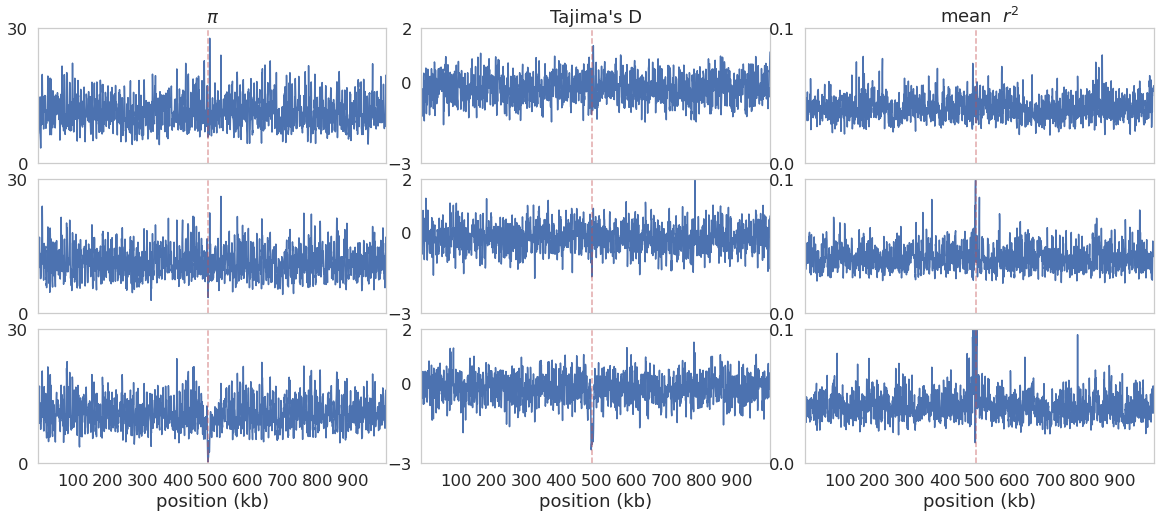

In [12]:
#####PLOT SUMMARY STATS FOR SINGLE SWEEP SIMULATIONS#####

sns.set(rc={'figure.figsize':(20,8),'axes.facecolor':'white','axes.edgecolor': '.8'},font_scale=1.5)
lst = [0,3,6]
ylabs = [r'$\pi$', "Tajima's D", r"mean  $r^2$"]
for i,j in enumerate(['100', '1000', '10000']):
    df = pd.read_csv(statsFile + j +"/"+str(r)+".stats", sep='\t',
                header=0)

    
    for a, stat in enumerate(['thetapi', 'tajimasd', 'meanrsq']):
        sp = lst[i]+a+1
        plt.subplot(3,3,sp)
        plt.plot(df[stat])
        plt.axvline(974.82, color='r', linestyle='--', alpha=0.5)
        if(stat=='thetapi'):
            plt.ylim([0,30])
            plt.yticks([0,30])
            
        elif(stat=='tajimasd'):
            plt.ylim([-3, 2])
            plt.yticks([-3, 0, 2])
            #plt.axhline(-2.8, color='r', linestyle='--', alpha=0.75)
            
        else:
            plt.ylim([0, 0.1])
            plt.yticks([0, 0.1])
            #plt.axhline(67, color='r', linestyle='--', alpha=0.75)


        plt.margins(x=0)
        
        
        if(sp>=7):
            plt.xlabel('position (kb)')
            plt.xticks([x for x in range(200, 2000, 200)], ['100','200','300','400','500','600','700','800','900'])
        else:plt.xticks([])
            
        if(sp<=3):
            plt.title(ylabs[sp-1])
#Adjust spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.12)